In [612]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [613]:
#constants / QuadCopter dimensions
g = 9.81 # gravity
k = 6.36105*10**-9  # propellar lift coefficient
b = 4.65133*10**-11  # drag coefficient

m_body = 0.7
l_body = 0.5
w_body = l_body
t_body = 0.1

m_arm = 0.05
l_arm = 0.4

l_rz = 0.05
#1 # z-distance between rotors and center of mass

In [614]:
def body_forces(w1, w2, w3, w4):
    taux = l_rz * k * (-w2**2 + w4**2)
    tauy = l_rz * k * (-w1**2 + w3**2)
    tauz = l_rz * b * (w1**2 - w2**2 + w3**2 - w4**2)

    fz = k * (w1**2 + w2**2 + w3**2 + w4**2)

    return taux, tauy, tauz, fz

In [615]:
#calcs moments of inertia 
m = 4*m_arm + m_body

I_xx_body = 1/12 * m_body*(w_body**2 + t_body**2)
I_yy_body = 1/12 * m_body*(l_body**2 + t_body**2)
I_zz_body = 1/12 * m_body *(w_body**2 + l_body**2)

I_xx_arm = 1/12 * m_arm * l_arm**2 + m_arm * (l_arm/2 + l_body/2)**2
I_yy_arm = 1/12 * m_arm * l_arm**2 + m_arm * (l_arm/2 + l_body/2)**2
I_zz_arm = I_yy_arm

Ixx = 2*I_xx_arm + I_xx_body
Iyy = 2*I_yy_arm + I_yy_body
Izz = 4*I_zz_arm + I_zz_body
Izz


0.07233333333333333

In [633]:
def quad_EOM(t, q, taux, tauy, tauz, fz):

    #must be first-order ODES
    '''
    Arguements:
        q : state vector :
        [px, py, pz, vx, vy, vz, phi, theta, psi, 
        omegax, omegay, omegaz, taux, tauy, tauz, fz]

        t : time
        p : various vector parameters : 
        [m, Ixx, Iyy, Izz]
    '''

    px, py, pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz = q

    C_phi = np.cos(phi)
    C_theta = np.cos(theta)
    C_psi = np.cos(psi)
    
    S_phi = np.sin(phi)
    S_theta = np.sin(theta)
    S_psi = np.sin(psi)

    vx_dot = -omegay*vz + omegaz*vy + g*S_theta
    vy_dot = omegax*vz - omegaz*vx - g*S_phi*C_theta
    vz_dot = fz/m - omegax*vy + omegay*vx - g*C_phi*C_theta

    px_dot = vx*C_psi*C_theta + vy*(S_phi*S_theta*C_psi - S_psi * C_phi) + vz * (S_phi * S_psi + S_theta*C_phi*C_psi)
    py_dot = vx*S_psi*C_theta + vy*(S_phi * S_psi * S_theta + C_phi * C_psi) - vz*(S_phi * C_psi - S_psi * S_theta * C_phi)
    pz_dot = -vx*S_theta + vy*S_phi*C_theta + vz * C_phi * C_theta


    phi_dot = omegax + omegay*S_phi*S_theta/C_theta + omegaz*C_phi*S_theta/C_theta
    theta_dot = omegay*C_phi - omegaz*S_phi
    psi_dot = 1/C_theta * (omegay*S_phi + omegaz*C_phi)

    omegax_dot = 1/Ixx * (Iyy*omegay*omegaz - Izz*omegay*omegaz + taux)
    omegay_dot = 1/Iyy * (-Ixx*omegax*omegaz + Izz*omegax * omegaz + tauy)
    omegaz_dot = 1/Izz * (Ixx*omegax*omegay - Iyy*omegax*omegay + tauz)



    EOM = [px_dot, py_dot, pz_dot, 
           vx_dot, vy_dot, vz_dot,
           phi_dot, theta_dot, psi_dot,
           omegax_dot, omegay_dot, omegaz_dot]
    
    return EOM 

In [635]:
F_net = np.sqrt((m*0.5**2/2)**2+(m*g)**2)

w = np.sqrt(F_net/(4*k))
    #fz = k * (w1**2 + w2**2 + w3**2 + w4**2)
init_theta = -np.arctan((m*0.5**2/2)/(m*g))
del_t = (np.pi/2)/(0.25)

omega_main = (np.pi/2)/del_t

#−0.0127414103580744
init_theta
omega_main
np.sin(-init_theta)

#0.125 = 0.5 *np.sin(-init_theta)
np.cos(init_theta)
init_theta

-0.012741410358074379

In [636]:
#propeller controls
#W = 8.828999999999999
#w = 18627.79106464644
    #clockwise
w1 = w
w3 = w
    #counter-clockwise
w2 = w
w4 = w


fr = body_forces(w1, w2, w3, w4)[3]
fr * np.sin(init_theta)
np.sqrt(fr/m * np.sin(init_theta)/2)
fr*np.sin(-init_theta)
0.5**2/2

C:\Users\prane\AppData\Local\Temp\ipykernel_33284\2057089299.py:14: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(fr/m * np.sin(init_theta)/2)


0.125

In [642]:
px0 = 4
py0 = 2
pz0 = 1
vx0 = 0.5
vy0 = 0
vz0 = 0
phi0 = init_theta
theta0 = 0#init_theta
psi0 = 0#-init_theta
omegax0 = 0 #init_omegax
omegay0 = 0
omegaz0 = -0.25

t = (0, 50)

init = [px0, py0, pz0, vx0, vy0, vz0, 
        phi0, theta0, psi0, omegax0, omegay0, omegaz0]

#controls
taux, tauy, tauz, fz = body_forces(w1, w2, w3, w4)

para =(taux, tauy, tauz, fz)
sol = solve_ivp(quad_EOM, t, init, max_step = 0.01, args = para)
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  6.838e-03 ...  5.000e+01  5.000e+01]
        y: [[ 4.000e+00  4.003e+00 ...  2.900e+01  2.900e+01]
            [ 2.000e+00  2.000e+00 ...  1.582e+02  1.582e+02]
            ...
            [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [-2.500e-01 -2.500e-01 ... -2.500e-01 -2.500e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 30008
     njev: 0
      nlu: 0

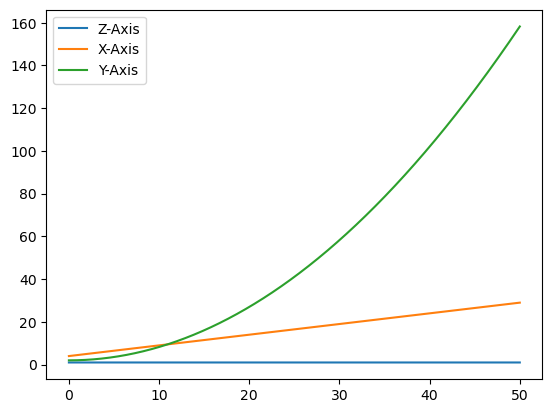

In [643]:
plt.plot(sol.t, sol.y[2], label = 'Z-Axis')
plt.plot(sol.t, sol.y[0], label = 'X-Axis')
plt.plot(sol.t, sol.y[1], label = 'Y-Axis')

plt.legend()
plt.show()

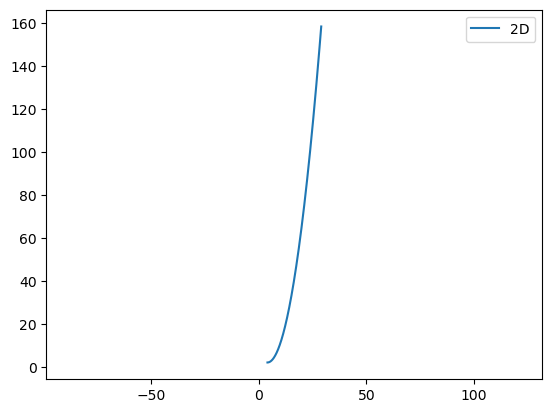

In [644]:
plt.plot(sol.y[0], sol.y[1], label = '2D')

plt.legend()
plt.axis('equal')
plt.show()

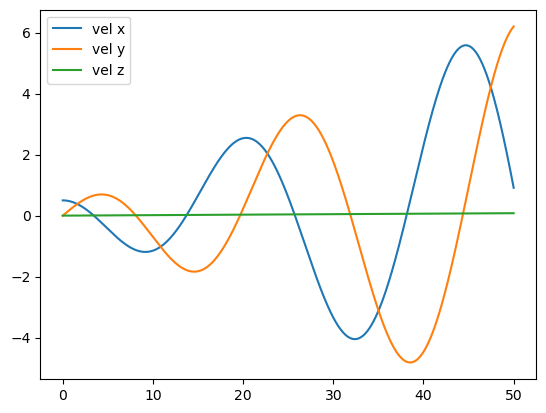

In [645]:
plt.plot(sol.t, sol.y[3], label = 'vel x')
plt.plot(sol.t, sol.y[4], label = 'vel y')
plt.plot(sol.t, sol.y[5], label = 'vel z')

plt.legend()
plt.show()

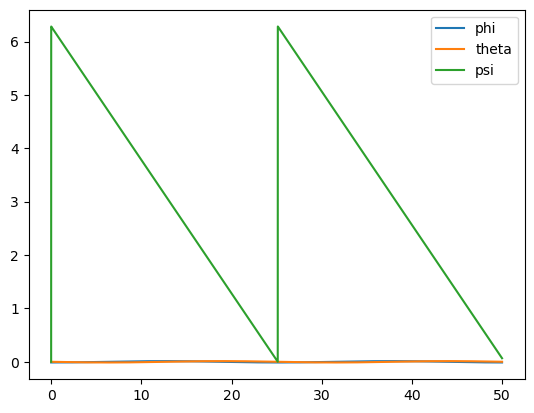

In [646]:
plt.plot(sol.t, sol.y[6], label = 'phi')
plt.plot(sol.t, sol.y[7], label = 'theta')
plt.plot(sol.t, sol.y[8]%(2*np.pi), label = 'psi')

plt.legend()
plt.show()

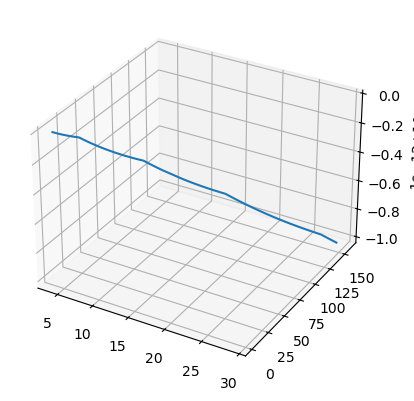

In [630]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.y[0], sol.y[1], sol.y[2])

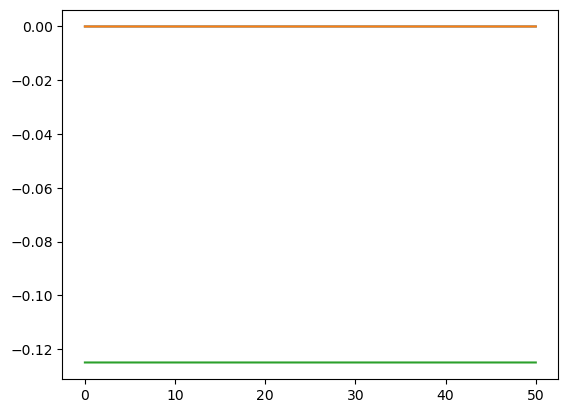

In [631]:
plt.plot(sol.t, sol.y[9], label = 'wx')
plt.plot(sol.t, sol.y[10], label = 'wy')
plt.plot(sol.t, sol.y[11], label = 'wz')

In [632]:
from sympy import *

q0     = 0.999979707126395     #rad

q1     = -0.00637066208567390     #rad

q2     = 0     #rad

q3     = 0     #rad



phi   = atan2(2*(q0*q1 + q2*q3), q0**2 - q1**2 - q2**2 + q3**2)
theta = asin(2*(q0*q2 - q3*q1))
psi   = atan2(2*(q0*q3 + q2*q1), q0**2 + q1**2 - q2**2 - q3**2)


In [602]:
phi

-0.0127414103580744

In [603]:
theta

0

In [273]:
psi

0